# Quantifying uncertainty in prediction

## Why study uncertainty in prediction in the first place?

A couple of reasons come to mind. Starting with the directions of this project: what if our model makes incorrect predictions on data outside the distribution they were trained on. This is called `extrapolation` and would mean that the model doesn't generalize well. But without a measure to quantify this, should we trust the model blindly?

This gives a second reason: the model itself can give this measure of uncertainty (or `confidence`) with it's predictions, which would make the analysis process easier.

## How to quantify this?

One such measure is entropy. For a random variable `X` it would be the amount of information required on average to encode it. There is quite the theory behind this, but the short story is that when we get an expected piece of information -> we become more certain -> large probability and low entropy. But, in a 50-50 scenario type information (or uniform distribution at that), the uncertainty would be the highest -> lowest probability and high entropy. The trick in implementing this in the following cases would be to find a threshold for this uncertainty (meaning, given a new sample from the distribution inferred my the model, what would be considered outliers?).


For a `classification` problem, the predictive posterior is a categorical distribution over the possible classes and we would be interested in the entropy of this distribution. For a `regression` problem, if we think of the target distribution as a sum of more iid distributions, than we would be interested in the entropy of this, which is the entropy of a Gaussian. 


The theory behind this is quite complex and big, but I tried my best with the 2 use cases below: 

# Initial Imports

In [127]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import math
import pymc as pm
import numpy as np
import pytensor.tensor as pt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import pytensor.tensor as pt
import arviz as az
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import seaborn as sns
from scipy.stats import entropy
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [65]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("Please install GPU version of TF")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Default GPU Device: /device:GPU:0


# Data Exploration

For the classification problem, I chose a dataset of images from 100 sports. Thus, this is an image classification problem.
Without treating it as a black-box type of challenge, there are many factors that can influence these pictures according to their context, such as:
- `football` images may have more green in them with a single round object
- `formula 1 racing` images should be one of the few categories to have cars in images

## Path Setup

In [66]:
classification_data_directory = "classification_data"
regression_data_directory = os.path.join("regression_data", 'housing.csv')
train_directory = os.path.join(classification_data_directory, 'train')
valid_directory = os.path.join(classification_data_directory, 'valid')
test_directory = os.path.join(classification_data_directory, 'test')

## Classification data - 100 sports

In [67]:
sport_types_train = [type for type in os.listdir(train_directory) if os.path.isdir(os.path.join(train_directory, type))]
sport_types_valid = [type for type in os.listdir(valid_directory) if os.path.isdir(os.path.join(valid_directory, type))]
sport_types_test = [type for type in os.listdir(test_directory) if os.path.isdir(os.path.join(test_directory, type))]
sport_types = list(set(sport_types_train + sport_types_valid + sport_types_test))

sport_types

['tennis',
 'balance beam',
 'hockey',
 'axe throwing',
 'archery',
 'judo',
 'hammer throw',
 'figure skating pairs',
 'bull riding',
 'speed skating',
 'pole vault',
 'horse jumping',
 'sidecar racing',
 'skydiving',
 'baton twirling',
 'rock climbing',
 'field hockey',
 'croquet',
 'sumo wrestling',
 'volleyball',
 'water polo',
 'tug of war',
 'rollerblade racing',
 'barell racing',
 'bobsled',
 'ice yachting',
 'boxing',
 'ampute football',
 'frisbee',
 'mushing',
 'pole dancing',
 'trapeze',
 'uneven bars',
 'horse racing',
 'canoe slamon',
 'roller derby',
 'lacrosse',
 'swimming',
 'harness racing',
 'jousting',
 'steer wrestling',
 'weightlifting',
 'golf',
 'wheelchair basketball',
 'bike polo',
 'basketball',
 'wheelchair racing',
 'formula 1 racing',
 'curling',
 'polo',
 'chuckwagon racing',
 'billiards',
 'rugby',
 'bungee jumping',
 'jai alai',
 'table tennis',
 'pole climbing',
 'fencing',
 'track bicycle',
 'sky surfing',
 'bmx',
 'snowmobile racing',
 'football',
 'sk

## Number of images per label 

Pretty much shows the raw set was inbalanced 

In [68]:
def count_images_in_folder(folder_path):
    return len([f for f in os.listdir(folder_path) if f.endswith('.jpg')])

data = []
for type in sport_types:
    train_count = count_images_in_folder(os.path.join(train_directory, type))
    valid_count = count_images_in_folder(os.path.join(valid_directory, type))
    test_count = count_images_in_folder(os.path.join(test_directory, type))
    data.append({'Type': type, 'Train': train_count, 'Test': test_count, 'Valid': valid_count})

sport_types_statistics = pd.DataFrame(data)
sport_types_statistics

Type  Train  Test  Valid
0                 tennis    131     5      5
1           balance beam    147     5      5
2                 hockey    172     5      5
3           axe throwing    113     5      5
4                archery    132     5      5
..                   ...    ...   ...    ...
95  figure skating women    157     5      5
96         water cycling    103     5      5
97           fly fishing    134     5      5
98              shot put    149     5      5
99               hurdles    136     5      5

[100 rows x 4 columns]

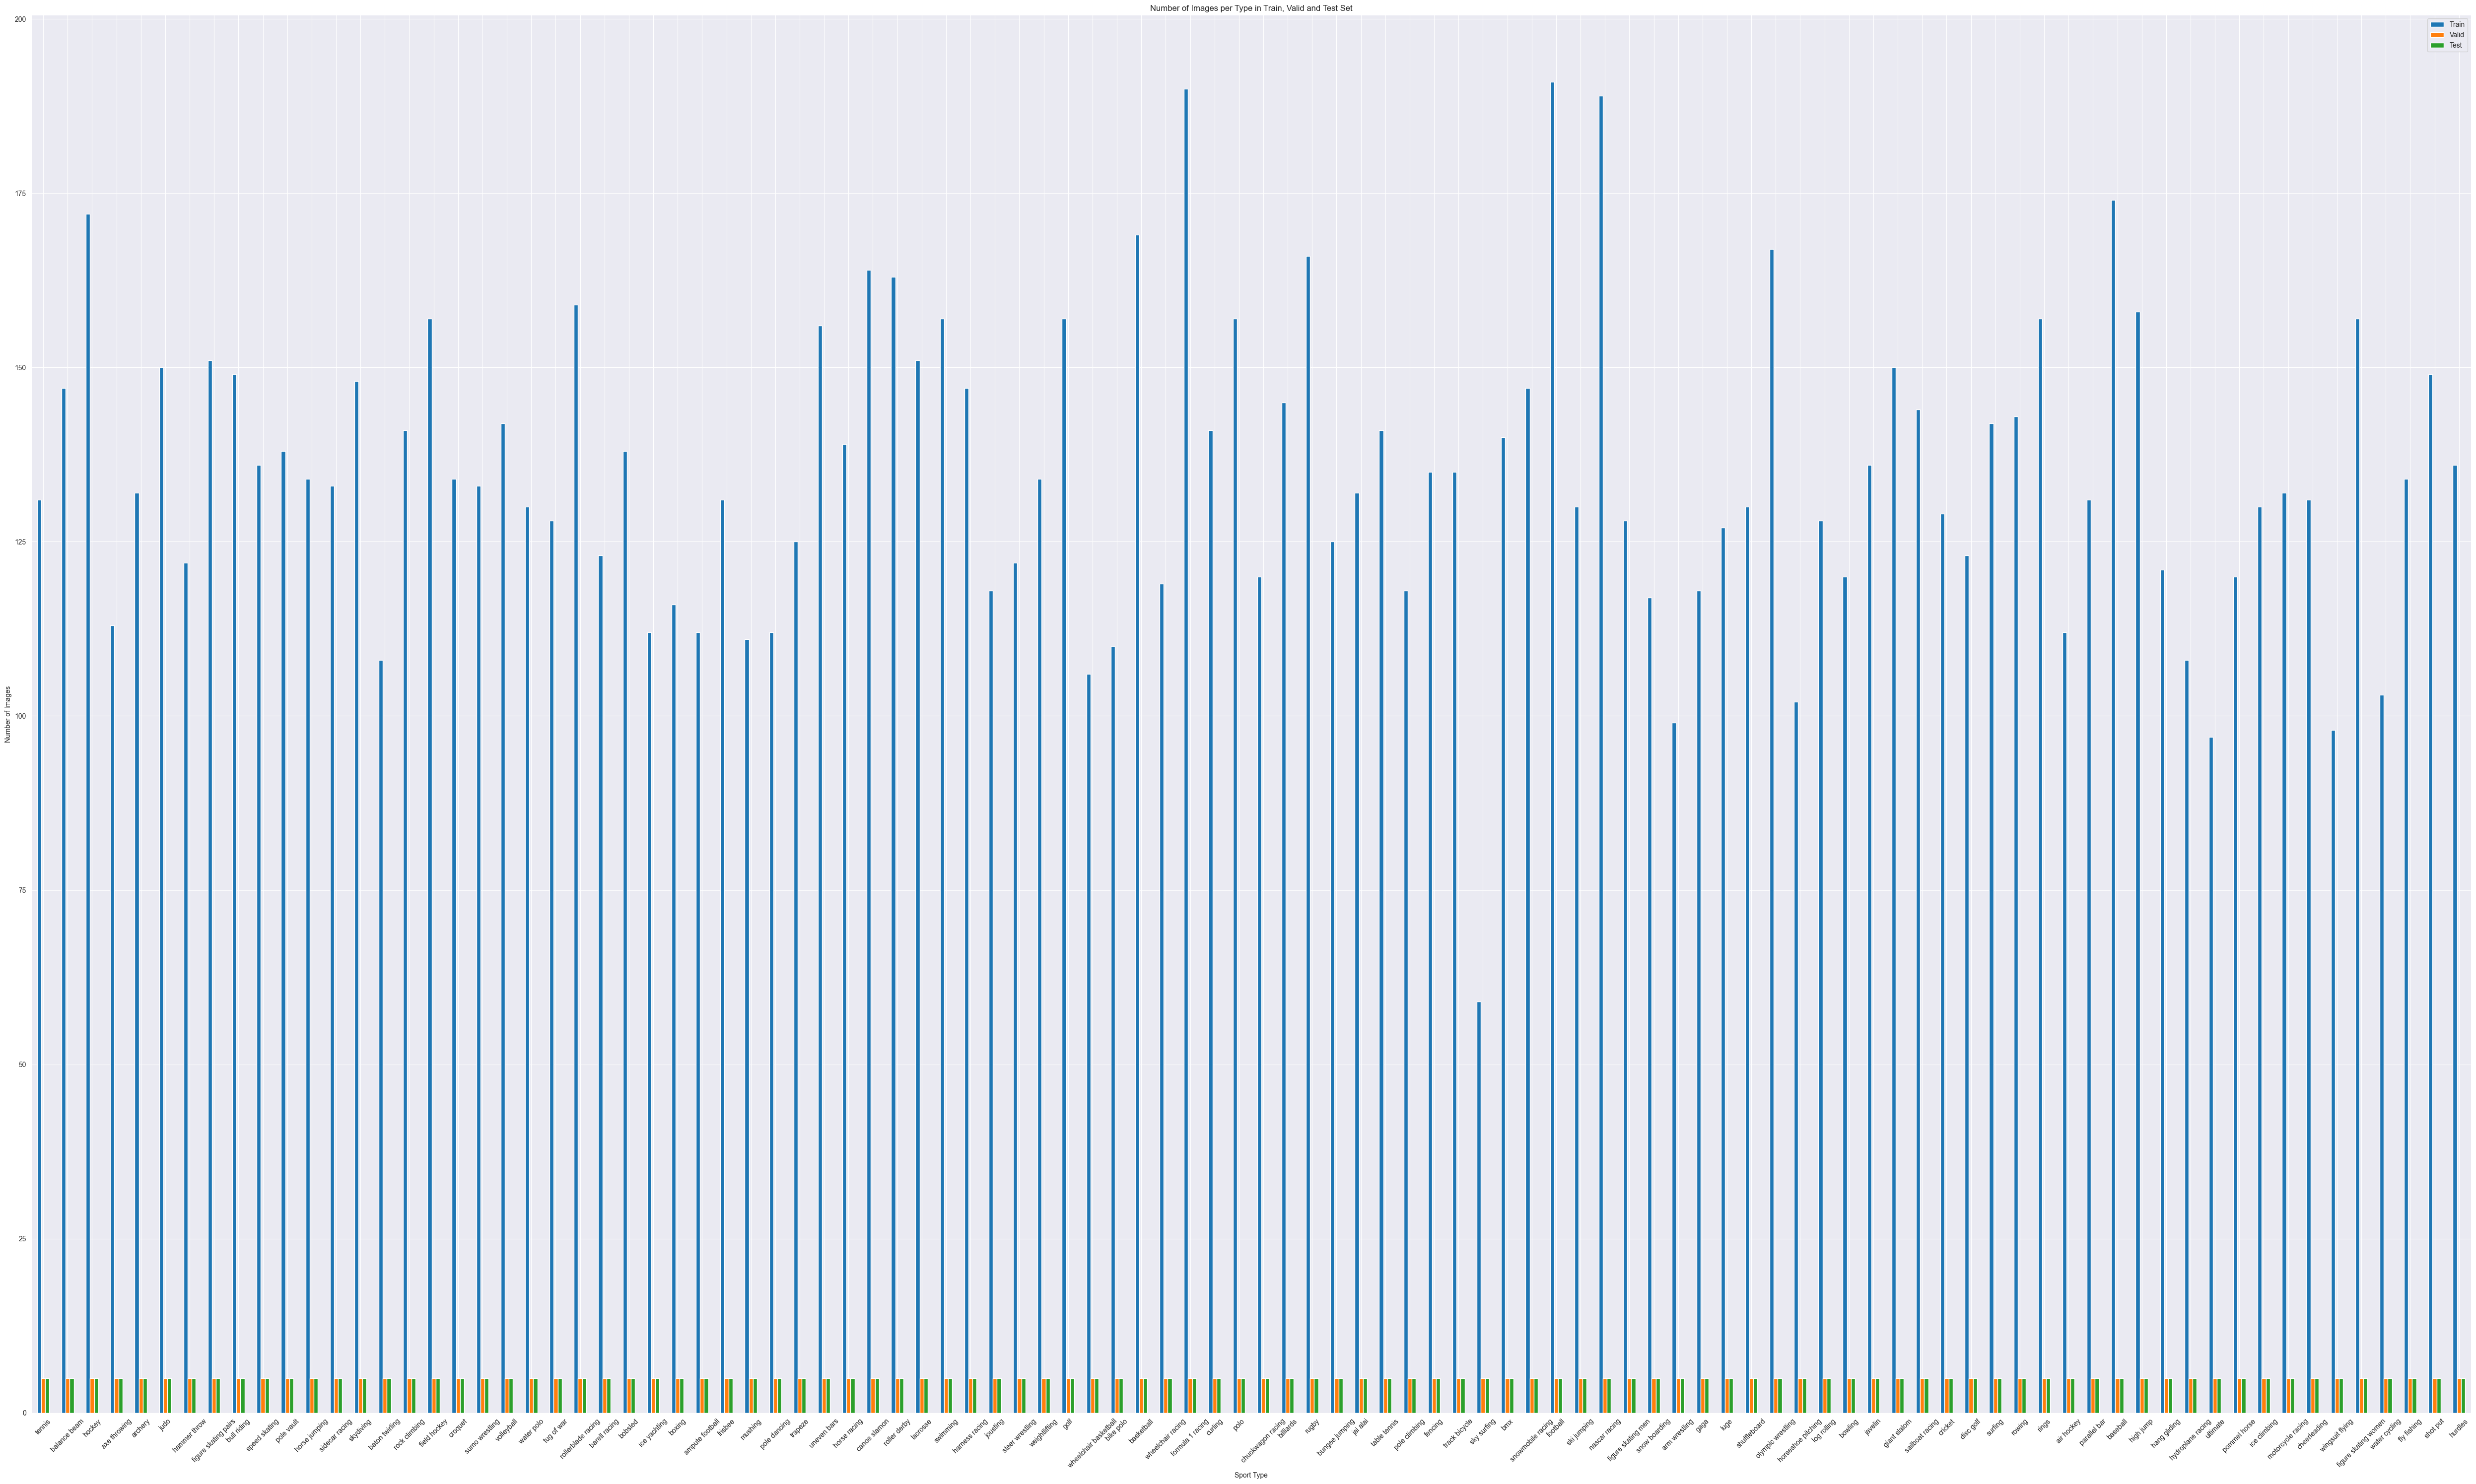

In [69]:
sport_types_statistics.set_index('Type')[['Train', 'Valid', 'Test']].plot(kind='bar', figsize=(50, 30))
plt.title('Number of Images per Type in Train, Valid and Test Set')
plt.ylabel('Number of Images')
plt.xlabel('Sport Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Common image size

In [70]:
def get_image_size(image_path):
    with Image.open(image_path) as img:
        return img.size  

image_sizes = []
for folder in [train_directory, valid_directory, test_directory]:
    for type in os.listdir(folder):
        sport_type_dir = os.path.join(folder, type)
        if os.path.isdir(sport_type_dir):
            for image_file in os.listdir(sport_type_dir):
                if image_file.endswith('.jpg'):
                    image_path = os.path.join(sport_type_dir, image_file)
                    image_sizes.append(get_image_size(image_path))

sizes_dataframe = pd.DataFrame(image_sizes, columns=['Width', 'Height'])
sizes_dataframe['Width'].unique(), sizes_dataframe['Height'].unique()

(array([224], dtype=int64), array([224], dtype=int64))

In [71]:
IMAGE_SIZE = (224, 224)
IMAGE_SHAPE = (224, 224, 3)

## Visualize samples from each label

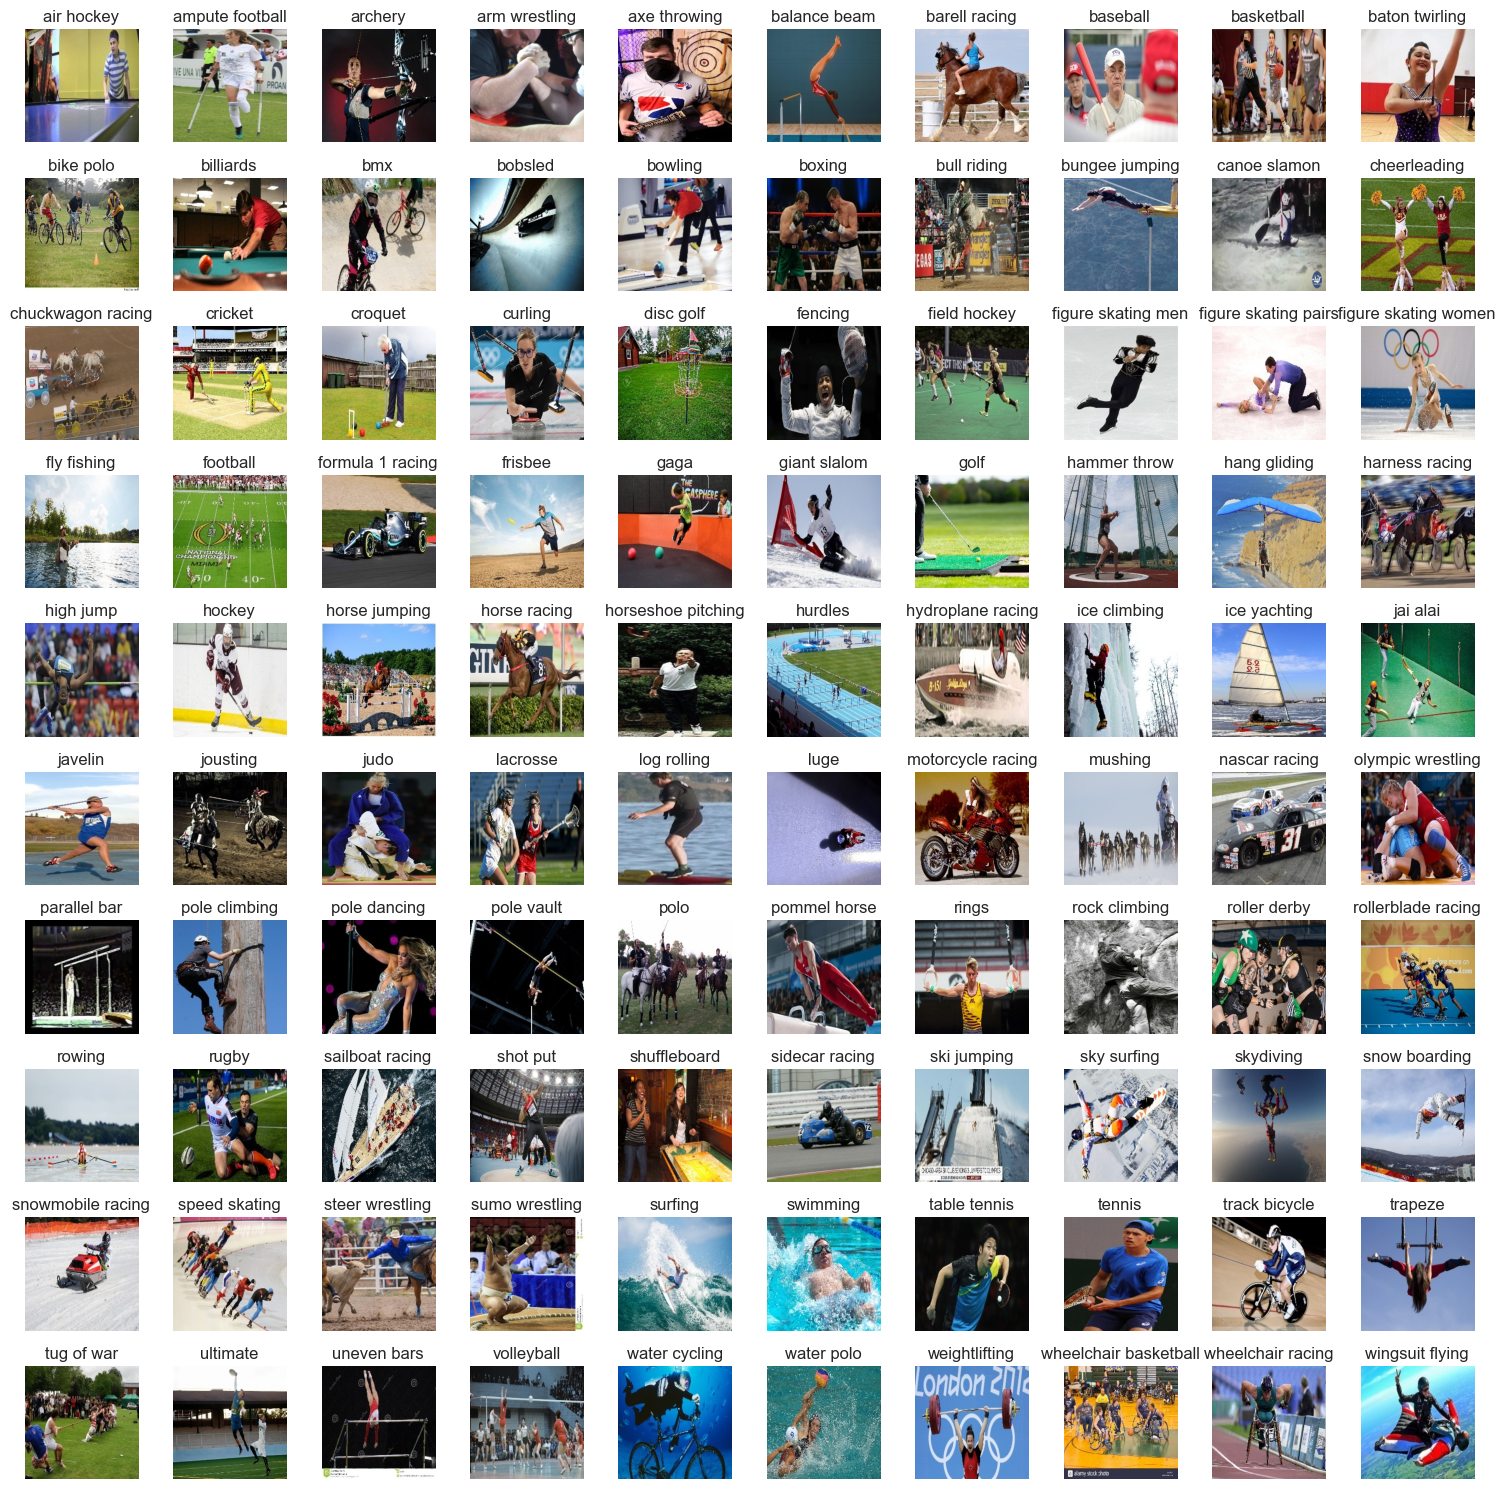

In [72]:
num_classes = len(sport_types_train)
grid_cols = math.ceil(math.sqrt(num_classes))  
grid_rows = math.ceil(num_classes / grid_cols)  

fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(15, 15))
axes = axes.flatten()  

for i, sport_type in enumerate(sport_types_train):
    sport_type_dir = os.path.join(train_directory, sport_type)
    image_files = [f for f in os.listdir(sport_type_dir) if f.endswith('.jpg')]
    
    if image_files:  
        image_path = os.path.join(sport_type_dir, image_files[0])
        with Image.open(image_path) as img:
            axes[i].imshow(np.array(img.resize(IMAGE_SIZE))) 
            axes[i].set_title(sport_type)
            axes[i].axis('off')
    else:
        axes[i].axis('off')  

for i in range(len(sport_types_train), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Preparing the data

## Classification data (choose train classes + unseen class)

I chose 10 classes for training, with the intention of taking ~ 100 samples each -> 1000 training samples overall.
The labels are represented by the folder in which the sample image is, so we should have the first 10 alphabetical labels:
- 'air hockey',
- 'ampute football',
- 'archery',
- 'arm wrestling',
- 'axe throwing',
- 'balance beam',
- 'barell racing',
- 'baseball',
- 'basketball',
- 'baton twirling'

And the unseen class should be: `bike polo`

In [73]:
CLASS_COUNT = 10
train_classes = sport_types_train[:CLASS_COUNT]
train_classes

['air hockey',
 'ampute football',
 'archery',
 'arm wrestling',
 'axe throwing',
 'balance beam',
 'barell racing',
 'baseball',
 'basketball',
 'baton twirling']

In [74]:
unseen_class = sport_types_train[CLASS_COUNT]
unseen_class

'bike polo'

In [75]:
class_to_label = {sport: idx for idx, sport in enumerate(train_classes)}
class_to_label[unseen_class] = CLASS_COUNT
class_to_label

{'air hockey': 0,
 'ampute football': 1,
 'archery': 2,
 'arm wrestling': 3,
 'axe throwing': 4,
 'balance beam': 5,
 'barell racing': 6,
 'baseball': 7,
 'basketball': 8,
 'baton twirling': 9,
 'bike polo': 10}

## Subset the data (earlier attempts took too long with all data)

I have 2 options here:
- use a fraction of the given data (attempted this because previous chain sampling took very long locally)
- use the whole data within a given limit (here I set 100 as max number of images per label, because this is the minimum between the labels - this is an unbalanced set)

In [76]:
def prepare_data(classes, data_dir):
    data = []
    labels = []
    for sport_type in classes:
        sport_type_dir = os.path.join(data_dir, sport_type)
        image_files = [os.path.join(sport_type_dir, f) for f in os.listdir(sport_type_dir) if f.endswith('.jpg')]
        
        # Assign the correct label using the mapping
        label = class_to_label[sport_type]
        
        data.extend(image_files)
        labels.extend([label] * len(image_files))
    
    return data, labels

In [77]:
def subset_data(data, labels, fraction=0.1):
    np.random.seed(42)
    indices = np.random.choice(len(data), size=int(len(data) * fraction), replace=False)
    return np.array(data)[indices], np.array(labels)[indices]

In [78]:
SUBSET_FRACTION = 0.15
TRAIN_IMAGES_RAW_LIMIT = 99
train_data = []
train_labels =[]
valid_data = []
valid_labels = []
test_data = []
test_labels = []
train_subset_data = []
train_subset_labels = []
valid_subset_data = []
valid_subset_labels = []
test_subset_data = []
test_subset_labels = []

for train_class in train_classes:
    train_class_data, train_class_labels = prepare_data([train_class], train_directory)
    train_class_data = train_class_data[:TRAIN_IMAGES_RAW_LIMIT]
    train_class_labels = train_class_labels[:TRAIN_IMAGES_RAW_LIMIT]
    train_class_subset_data, train_class_subset_labels = subset_data(train_class_data, train_class_labels, fraction=SUBSET_FRACTION)
    train_data.extend(train_class_data)
    train_labels.extend(train_class_labels)
    train_subset_data.extend(train_class_subset_data)
    train_subset_labels.extend(train_class_subset_labels)
    
    valid_class_data, valid_class_labels = prepare_data([train_class], valid_directory)
    valid_class_subset_data, valid_class_subset_labels = subset_data(valid_class_data, valid_class_labels, fraction=2*SUBSET_FRACTION)
    valid_data.extend(valid_class_data)
    valid_labels.extend(valid_class_labels)
    valid_subset_data.extend(valid_class_subset_data)
    valid_subset_labels.extend(valid_class_subset_labels)

    test_class_data, test_class_labels = prepare_data([train_class], test_directory)
    test_class_subset_data, test_class_subset_labels = subset_data(test_class_data, test_class_labels, fraction=2*SUBSET_FRACTION)
    test_data.extend(test_class_data)
    test_labels.extend(test_class_labels)
    test_subset_data.extend(test_class_subset_data)
    test_subset_labels.extend(test_class_subset_labels)
   
combined_test_data = np.concatenate([test_data, valid_data])
combined_test_labels = np.concatenate([test_labels, valid_labels])    
combined_test_subset_data = np.concatenate([test_subset_data, valid_subset_data])
combined_test_subset_labels = np.concatenate([test_subset_labels, valid_subset_labels])

print("Training Data Shape:", len(train_data))
print("Training Subset Data Shape:", len(train_subset_data))
print("Testing Data Shape:", len(combined_test_data))
print("Testing Subset Data Shape:", len(combined_test_subset_data))

Training Data Shape: 990
Training Subset Data Shape: 140
Testing Data Shape: 100
Testing Subset Data Shape: 20


In [79]:
unseen_train_data, unseen_train_labels = prepare_data([unseen_class], train_directory)
unseen_train_data = unseen_train_data[:TRAIN_IMAGES_RAW_LIMIT]
unseen_train_labels = unseen_train_labels[:TRAIN_IMAGES_RAW_LIMIT]
unseen_train_subset_data, unseen_train_subset_labels = subset_data(unseen_train_data, unseen_train_labels, fraction=SUBSET_FRACTION)

unseen_valid_data, unseen_valid_labels = prepare_data([unseen_class], valid_directory)
unseen_valid_subset_data, unseen_valid_subset_labels = subset_data(unseen_valid_data, unseen_valid_labels, fraction=2*SUBSET_FRACTION)
unseen_test_data, unseen_test_labels = prepare_data([unseen_class], test_directory)
unseen_test_subset_data, unseen_test_subset_labels = subset_data(unseen_test_data, unseen_test_labels, fraction=2*SUBSET_FRACTION)

combined_unseen_test_data = np.concatenate([unseen_test_data, unseen_valid_data])
combined_unseen_test_subset_data = np.concatenate([unseen_test_subset_data, unseen_valid_subset_data])
combined_unseen_test_labels = np.concatenate([unseen_test_labels, unseen_valid_labels])
combined_unseen_test_subset_labels = np.concatenate([unseen_test_subset_labels, unseen_valid_subset_labels])

print("Unseen Training Data Shape:", len(unseen_train_data))
print("Unseen Training Subset Data Shape:", len(unseen_train_subset_data))
print("Unseen Testing Data Shape:", len(combined_unseen_test_data))
print("Unseen Testing Subset Data Shape:", len(combined_unseen_test_subset_data))

Unseen Training Data Shape: 99
Unseen Training Subset Data Shape: 14
Unseen Testing Data Shape: 10
Unseen Testing Subset Data Shape: 2


## Feature extraction using ResNet50 + PCA

Used pretrained model to extract vectorized embeddings.
Because initial vector size was 2048, it made the whole process a lot slower (not only that, but because of local limitations, features had to be extracted in batches).

Because of this, I decided to use PCA, which is a compression method, to keep the most relevant features.

In [80]:
feature_extractor = tf.keras.applications.ResNet50(
    include_top=False, input_shape=IMAGE_SHAPE, pooling='avg', weights='imagenet'
)

In [81]:
def extract_features(image_paths):
    images = [
        tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(p)), IMAGE_SIZE) 
        for p in image_paths
    ]
    images = tf.stack(images) / 255.0 
    return feature_extractor(images).numpy()

In [82]:
def extract_features_in_batches(image_paths, batch_size=32):
    features = []
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        batch_images = [
            tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(p)), IMAGE_SIZE) 
            for p in batch_paths
        ]
        batch_images = tf.stack(batch_images) / 255.0 
        batch_features = feature_extractor(batch_images).numpy()
        features.append(batch_features)
    return np.concatenate(features, axis=0)

In [83]:
train_features = extract_features_in_batches(train_data) 
test_features = extract_features_in_batches(combined_test_data)
unseen_train_features = extract_features_in_batches(unseen_train_data)
unseen_test_features = extract_features_in_batches(combined_unseen_test_data)
train_features.shape, test_features.shape, unseen_train_features.shape, unseen_test_features.shape

((990, 2048), (100, 2048), (99, 2048), (10, 2048))

In [84]:
pca = PCA(n_components=99)

In [85]:
train_features_pca = pca.fit_transform(train_features)
test_features_pca = pca.transform(test_features)
unseen_train_features_pca = pca.fit_transform(unseen_train_features)
unseen_test_features_pca = pca.transform(unseen_test_features)
train_features_pca.shape, test_features_pca.shape, unseen_train_features_pca.shape, unseen_test_features_pca.shape

((990, 99), (100, 99), (99, 99), (10, 99))

# Bayesian Neural Network

## Setting the architecture and the utility functions

There were some good pieces of documentation / info out there, such as:
- [PYMC Officials Docs on Bayesian Neural Networks](https://www.pymc.io/projects/examples/en/latest/variational_inference/bayesian_neural_network_advi.html)
- [Stackoverflow problem on IRIS dataset](https://stackoverflow.com/questions/54181136/how-to-make-a-simple-bayesian-neural-network-for-multiclass-classification-in-py)
- [PYMC YT video for Biotech](https://www.youtube.com/watch?v=H4wPPfRztyk&list=PL1Ma_1DBbE82OVW8Fz_6Ts1oOeyOAiovy&index=40) (this was more for me to get used to some structures)

In [86]:
def relu(x):
  return pt.switch(pt.lt(x, 0), 0, x)

def softmax(x):
    exp_x = pt.exp(x - pt.max(x, axis=1, keepdims=True)) 
    return exp_x / pt.sum(exp_x, axis=1, keepdims=True)

def multiclass_bayesian_network(input_data, output_data, hidden_variables_count=128, num_classes_param=None):
    if num_classes is None:
        raise ValueError("num_classes must be specified")

    with pm.Model() as bnn_model:
        features_data = pm.Data("input_data", input_data)
        labels_data  = pm.Data("output_data", output_data)

        weights_1 = pm.Normal("W1", mu=0, sigma=0.5, shape=(features_data.shape[1], hidden_variables_count))
        bias_1 = pm.Normal("b1", mu=0, sigma=0.5, shape=(hidden_variables_count,))
        hidden = relu(pt.dot(features_data, weights_1) + bias_1)

        weights_2 = pm.Normal("W2", mu=0, sigma=0.5, shape=(hidden_variables_count, num_classes_param))
        bias_2 = pm.Normal("b2", mu=0, sigma=0.5, shape=(num_classes_param,))
        output_logits = pt.dot(hidden, weights_2) + bias_2
        output_probs = pm.Deterministic("output_probs", softmax(output_logits))

        y_obs = pm.Categorical("y_obs", p=output_probs, observed=labels_data)
    
    return bnn_model

In [113]:
multiclass_bayesian_model = multiclass_bayesian_network(train_features_pca, train_labels, hidden_variables_count=192, num_classes_param=CLASS_COUNT+1)

In [114]:
with multiclass_bayesian_model:
    approx = pm.fit(n = 50000)

bayesian_model_trace = approx.sample(draws = 5000)

Output()

Finished [100%]: Average Loss = 2,964.4


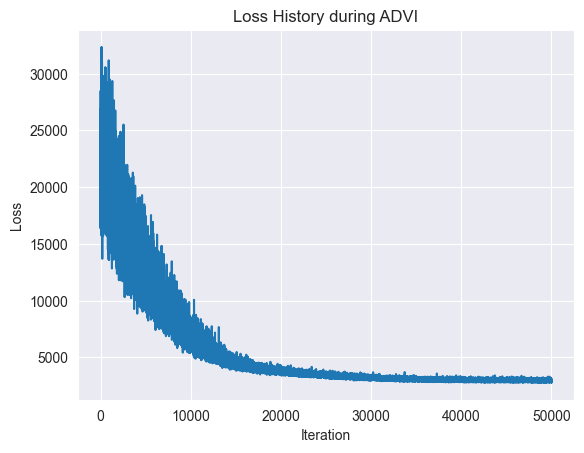

In [115]:
plt.plot(approx.hist)
plt.title("Loss History during ADVI")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

## Generating predictions on posterior and evaluating it on the training set

That would be the whole purpose and by comparing the predictions, we get a better idea of the uncertainties (it makes more sens on unseen/testing data)
This section's evaluation will be on the training set

In [139]:
with multiclass_bayesian_model:
    posterior_predictions = pm.sample_posterior_predictive(bayesian_model_trace, var_names=["output_probs"])

posterior_probabilities = posterior_predictions.posterior_predictive["output_probs"]

Sampling: [W1]


Output()

In [117]:
posterior_probabilities_combined = posterior_probabilities.values.reshape(
    -1, 
    posterior_probabilities.shape[2],
    posterior_probabilities.shape[3]  
)
posterior_probabilities_combined.shape

(5000, 990, 11)

In [118]:
mean_probabilities = posterior_probabilities_combined.mean(axis=0)
mean_probabilities.shape

(990, 11)

In [119]:
predicted_classes = np.argmax(mean_probabilities, axis=1)
predicted_classes.shape

(990,)

In [120]:
predicted_classes = np.argmax(mean_probabilities, axis=1)
accuracy = accuracy_score(train_labels, predicted_classes)
print(f"BNN Training Set Accuracy: {accuracy * 100:.2f}%")

BNN Training Set Accuracy: 60.81%


## Visualize the weights posterior distributions

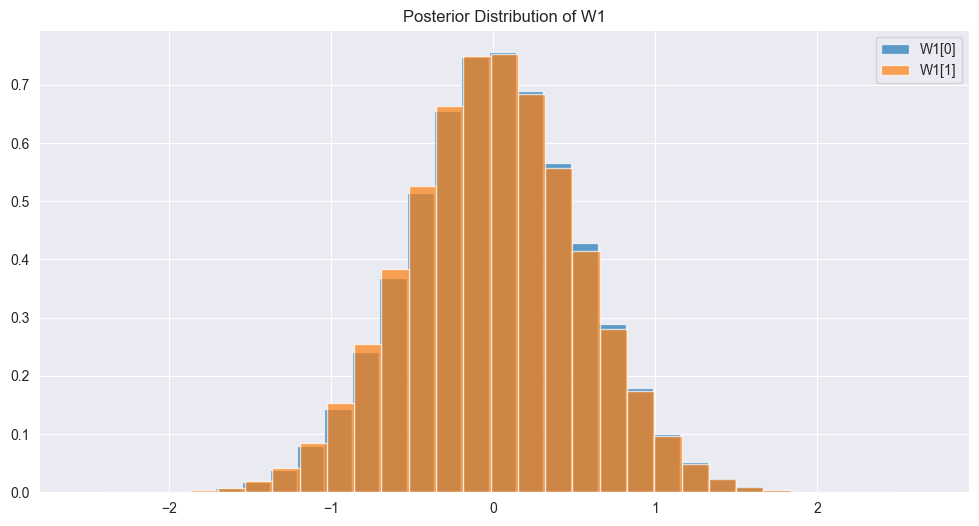

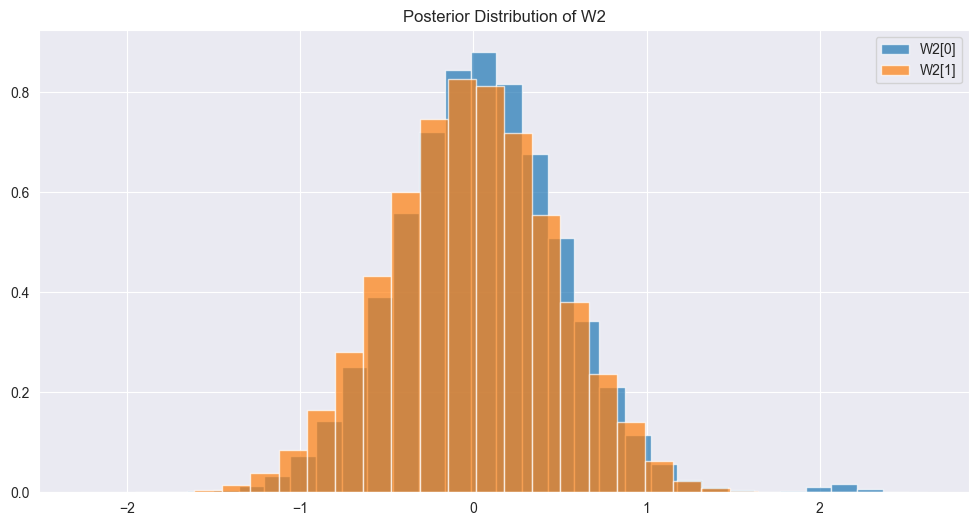

In [121]:
weights_1_samples = bayesian_model_trace.posterior["W1"].values
weights_2_samples = bayesian_model_trace.posterior["W2"].values

weights_1_flat = weights_1_samples.reshape(-1, weights_1_samples.shape[-1])
weights_2_flat = weights_2_samples.reshape(-1, weights_2_samples.shape[-1])

plt.figure(figsize=(12, 6))
plt.hist(weights_1_flat[:, 0], bins=30, density=True, alpha=0.7, label="W1[0]")
plt.hist(weights_1_flat[:, 1], bins=30, density=True, alpha=0.7, label="W1[1]")
plt.title("Posterior Distribution of W1")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(weights_2_flat[:, 0], bins=30, density=True, alpha=0.7, label="W2[0]")
plt.hist(weights_2_flat[:, 1], bins=30, density=True, alpha=0.7, label="W2[1]")
plt.title("Posterior Distribution of W2")
plt.legend()
plt.show()

## Evaluate on the testing set

In [122]:
def entropy(probabilities):
    return -np.sum(probabilities * np.log(probabilities + 1e-10), axis=1)

In [171]:
with multiclass_bayesian_model:
    pm.set_data({"input_data": test_features_pca, "output_data": combined_test_labels})
    posterior_pred_test = pm.sample_posterior_predictive(bayesian_model_trace, var_names=["output_probs"])

Sampling: [W1]


Output()

In [172]:
test_mean_probs = np.mean(np.squeeze(posterior_pred_test.posterior_predictive["output_probs"]), axis=0) 

test_epistemic_uncertainty = np.var(np.squeeze(posterior_pred_test.posterior_predictive["output_probs"]), axis=0) 
test_aleatoric_uncertainty = entropy(test_mean_probs.T)

test_max_epistemic_uncertainty = test_epistemic_uncertainty.max(axis=0) 
test_novel_classes = test_epistemic_uncertainty.max(axis=1) > 0.1

print("Novel classes detected:", test_novel_classes)
print("Mean probabilities:", test_mean_probs[0])
print("Epistemic uncertainty:", test_epistemic_uncertainty[0])
print("Aleatoric uncertainty:", test_aleatoric_uncertainty)

Novel classes detected: <xarray.DataArray 'output_probs' (output_probs_dim_2: 100)> Size: 100B
array([ True,  True, False, False,  True,  True, False, False,  True,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False,  True, False, False,  True, False, False, False,
        True, False, False, False, False,  True, False,  True,  True,
        True,  True, False,  True, False,  True,  True, False,  True,
       False, False, False,  True, False, False,  True, False, False,
       False, False,  True, False,  True,  True, False, False, False,
       False, False, False, False, False,  True, False,  True, False,
       False, False, False, False, False,  True, False, False, False,
        True,  True,  True, False,  True, False, False, False, False,
       False])
Coordinates:
    chain               int32 4B 0
  * output_probs_dim_2  (output_probs_dim_2) int32 400B 0 1 2 3 ... 96 9

In [173]:
test_probs = posterior_pred_test.posterior_predictive["output_probs"].mean(axis=(0, 1)).values
test_uncertainty = posterior_pred_test.posterior_predictive["output_probs"].std(axis=(0, 1)).values

test_predictions = np.argmax(test_probs, axis=1)
accuracy = accuracy_score(combined_test_labels, test_predictions)
print(f"BNN Testing Set Accuracy: {accuracy * 100:.2f}%")

BNN Testing Set Accuracy: 9.00%


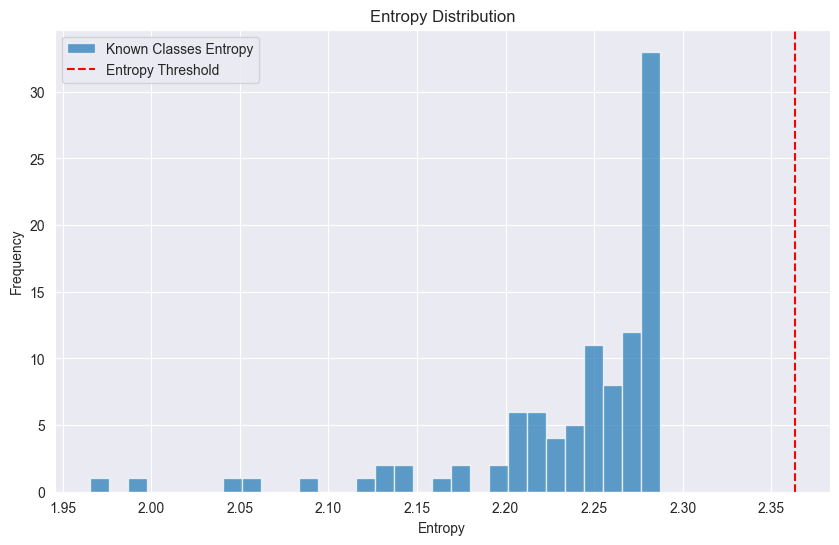

In [124]:
test_entropies = entropy(test_probs)
entropy_threshold = test_entropies.mean() + 2 * test_entropies.std()

plt.figure(figsize=(10, 6))
plt.hist(test_entropies, bins=30, alpha=0.7, label="Known Classes Entropy")
plt.axvline(entropy_threshold, color="red", linestyle="--", label="Entropy Threshold")
plt.legend()
plt.title("Entropy Distribution")
plt.xlabel("Entropy")
plt.ylabel("Frequency")
plt.show()

## Then evaluate it for the unseen class set

The key is to use the uncertainty in the model's predictions to identify whether an example belongs to a class that the model has seen during training. Typically, a "high uncertainty" prediction means the model is not confident, which could indicate that the example is from an unseen class.

**Entropy**: One approach is to measure the uncertainty by computing the entropy of the predicted class probabilities. If the entropy is high, it suggests the model is uncertain, which could indicate an unseen class.

In [174]:
with multiclass_bayesian_model:
    pm.set_data({"input_data": unseen_train_features_pca, "output_data": unseen_train_labels})
    posterior_pred_unseen  = pm.sample_posterior_predictive(bayesian_model_trace, var_names=["output_probs"])

Sampling: [W1]


Output()

In [175]:
unseen_mean_probs = np.mean(np.squeeze(posterior_pred_unseen.posterior_predictive["output_probs"]), axis=0) 

unseen_epistemic_uncertainty = np.var(np.squeeze(posterior_pred_unseen.posterior_predictive["output_probs"]), axis=0) 
unseen_aleatoric_uncertainty = entropy(test_mean_probs.T)

unseen_max_epistemic_uncertainty = unseen_epistemic_uncertainty.max(axis=0) 
unseen_novel_classes = unseen_epistemic_uncertainty.max(axis=1) > 0.1

print("Novel classes detected:", unseen_novel_classes)
print("Mean probabilities:", unseen_mean_probs[0])
print("Epistemic uncertainty:", unseen_epistemic_uncertainty[0])
print("Aleatoric uncertainty:", unseen_aleatoric_uncertainty)

Novel classes detected: <xarray.DataArray 'output_probs' (output_probs_dim_2: 99)> Size: 99B
array([ True, False, False,  True, False,  True, False, False, False,
        True,  True, False,  True,  True, False, False, False, False,
       False,  True,  True, False, False, False,  True,  True,  True,
        True, False, False, False,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True, False,  True,
        True,  True, False,  True,  True,  True, False,  True,  True,
       False, False, False, False, False, False,  True, False, False,
       False, False,  True,  True,  True, False, False, False,  True,
        True, False, False, False,  True,  True,  True, False, False,
        True,  True,  True, False, False,  True,  True, False, False,
       False,  True, False,  True, False,  True, False,  True, False])
Coordinates:
    chain               int32 4B 0
  * output_probs_dim_2  (output_probs_dim_2) int32 396B 0 1 2 3 ... 95 96 97 98
Mean pro

In [ ]:
unseen_probs  = posterior_pred_test.posterior_predictive["output_probs"].mean(axis=(0, 1)).values
unseen_uncertainty  = posterior_pred_test.posterior_predictive["output_probs"].std(axis=(0, 1)).values

unseen_predictions = np.argmax(unseen_probs, axis=1)
accuracy = accuracy_score(unseen_train_labels, unseen_predictions[:TRAIN_IMAGES_RAW_LIMIT])
print(f"BNN Testing Set Accuracy: {accuracy * 100:.2f}%")

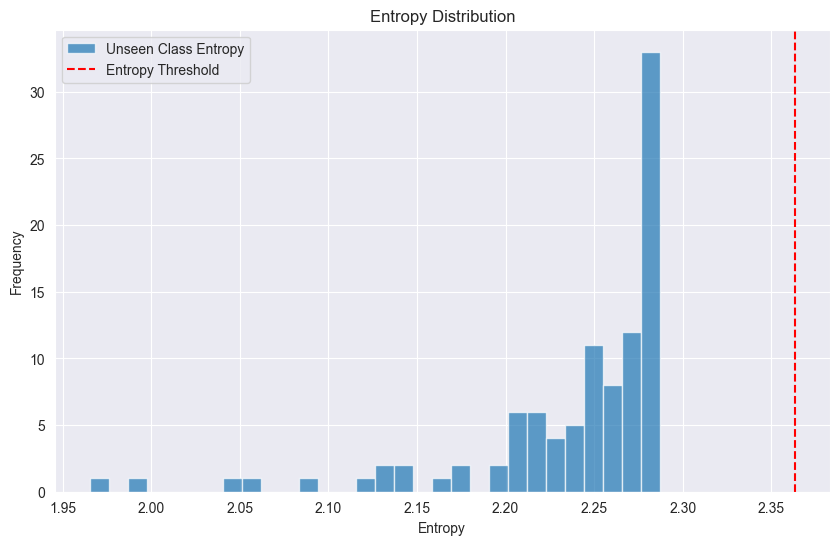

In [126]:
unseen_entropies = entropy(unseen_probs)
unseen_entropy_threshold = unseen_entropies.mean() + 2 * unseen_entropies.std()

plt.figure(figsize=(10, 6))
plt.hist(unseen_entropies, bins=30, alpha=0.7, label="Unseen Class Entropy")
plt.axvline(unseen_entropy_threshold, color="red", linestyle="--", label="Entropy Threshold")
plt.legend()
plt.title("Entropy Distribution")
plt.xlabel("Entropy")
plt.ylabel("Frequency")
plt.show()

# Using classical CNNs

## Setting the architecture 

Will use a convolutional neural network for this multiclass image classification problem -> done using tensorflow

In [44]:
def build_cnn_model(input_shape, num_classes_param):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))
    model.add(layers.Reshape((input_shape[0], 1))) 
    model.add(layers.Conv1D(64, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(128, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes_param, activation='softmax'))  
    return model

## Building the CNN model and train it

The same data will be used for a fair comparison

In [45]:
multiclass_cnn_model = build_cnn_model((train_features_pca.shape[1],), CLASS_COUNT)

multiclass_cnn_model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

multiclass_cnn_model_history = multiclass_cnn_model.fit(
    train_features_pca, 
    np.array(train_labels), 
    epochs=20, 
    batch_size=32, 
    validation_data=(test_features_pca, np.array(combined_test_labels)))

Epoch 1/20
31/31 [==============================] - 2s 19ms/step - loss: 2.2813 - accuracy: 0.1657 - val_loss: 2.1814 - val_accuracy: 0.2600
Epoch 2/20
31/31 [==============================] - 0s 6ms/step - loss: 2.1372 - accuracy: 0.2313 - val_loss: 1.8984 - val_accuracy: 0.4000
Epoch 3/20
31/31 [==============================] - 0s 6ms/step - loss: 1.9293 - accuracy: 0.3384 - val_loss: 1.6939 - val_accuracy: 0.4200
Epoch 4/20
31/31 [==============================] - 0s 7ms/step - loss: 1.7967 - accuracy: 0.3778 - val_loss: 1.6403 - val_accuracy: 0.4400
Epoch 5/20
31/31 [==============================] - 0s 6ms/step - loss: 1.6455 - accuracy: 0.4475 - val_loss: 1.5402 - val_accuracy: 0.5400
Epoch 6/20
31/31 [==============================] - 0s 6ms/step - loss: 1.5589 - accuracy: 0.4636 - val_loss: 1.4450 - val_accuracy: 0.5400
Epoch 7/20
31/31 [==============================] - 0s 6ms/step - loss: 1.4431 - accuracy: 0.5141 - val_loss: 1.3927 - val_accuracy: 0.5700
Epoch 8/20
31/31 [=

## Plotting the training curves

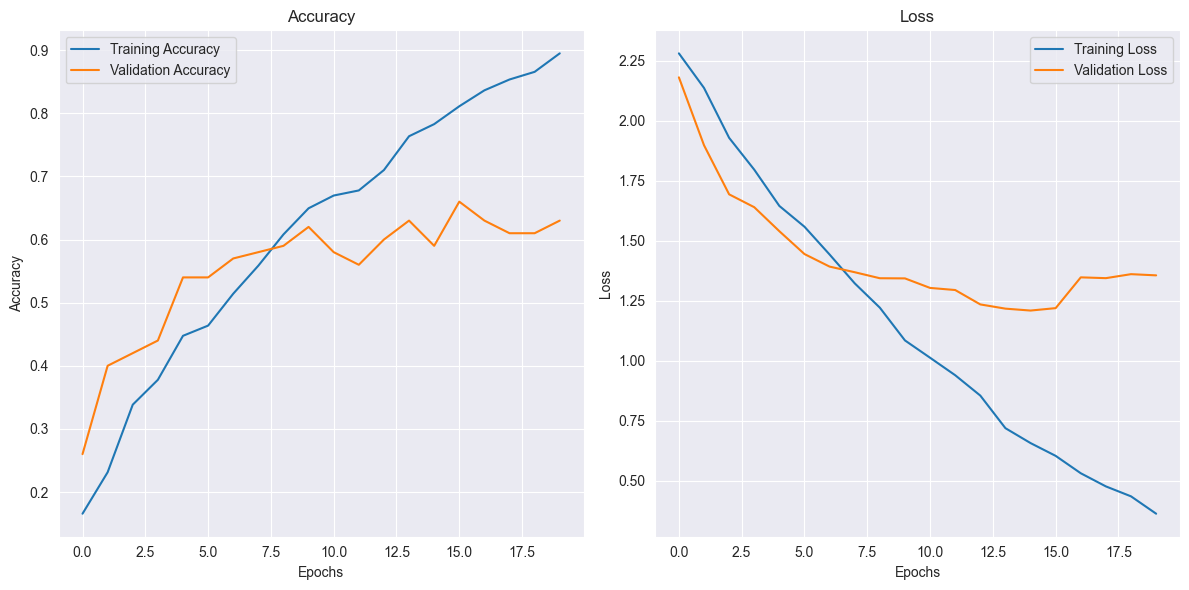

In [46]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(multiclass_cnn_model_history.history['accuracy'], label='Training Accuracy')
plt.plot(multiclass_cnn_model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(multiclass_cnn_model_history.history['loss'], label='Training Loss')
plt.plot(multiclass_cnn_model_history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Predicting on the unseen data using CNN

Just like before, this is expected to give answers from existing training labels, but we have to measure this uncertainty

In [47]:
def predict_unseen_class_with_cnn(model, data, threshold=0.6):
    cnn_predictions = model.predict(data)
    cnn_max_probs = np.max(cnn_predictions, axis=1)
    
    cnn_predicted_classes = np.argmax(cnn_predictions, axis=1)
    cnn_predicted_labels = [cnn_predicted_classes[i] if cnn_max_probs[i] > threshold else CLASS_COUNT 
                        for i in range(len(cnn_predictions))]
    
    return cnn_predicted_labels, cnn_max_probs

In [48]:
cnn_predicted_labels,cnn_max_probabilities = predict_unseen_class_with_cnn(multiclass_cnn_model, unseen_train_features_pca)

print("Predicted Labels for Unseen Train Data: ", cnn_predicted_labels)
print("Max Probabilities for Each Sample: ", cnn_max_probabilities)

cnn_unseen_accuracy = np.sum(np.array(cnn_predicted_labels) == np.array(unseen_train_labels)) / len(cnn_predicted_labels)
print(f"Unseen Test Accuracy (CNN model): {cnn_unseen_accuracy * 100:.2f}%")

4/4 [==============================] - 0s 48ms/step
Predicted Labels for Unseen Train Data:  [3, 10, 10, 10, 10, 0, 10, 2, 10, 9, 8, 10, 7, 10, 3, 10, 3, 10, 0, 10, 10, 10, 1, 3, 10, 0, 8, 10, 0, 10, 5, 10, 4, 8, 3, 0, 0, 8, 0, 10, 10, 7, 7, 10, 3, 7, 10, 0, 5, 7, 7, 3, 10, 8, 5, 10, 10, 10, 5, 3, 10, 0, 10, 10, 3, 9, 10, 9, 8, 3, 10, 7, 10, 4, 6, 10, 2, 6, 5, 10, 3, 5, 10, 8, 8, 10, 10, 7, 10, 10, 0, 6, 3, 3, 10, 9, 10, 0, 6]
Max Probabilities for Each Sample:  [0.9064329  0.45054948 0.5946742  0.5511862  0.3530587  0.87295985
 0.51526433 0.8329291  0.45422179 0.97006536 0.7646488  0.38729084
 0.84711635 0.4400103  0.9416331  0.30798355 0.795604   0.28646448
 0.91080946 0.5087042  0.52449185 0.45686173 0.88511413 0.9911891
 0.54418766 0.9676108  0.998692   0.34801716 0.92508197 0.3443876
 0.7578489  0.34213483 0.63492376 0.96395475 0.6586164  0.6747164
 0.9903346  0.7748831  0.7374502  0.4587058  0.43695304 0.9827419
 0.82170707 0.25135395 0.9580979  0.9862872  0.49005967 0.6529061
 0

# Nonlinear Regression Problem

Similar comparison problem as above, except, for a more complex regression problem. Purpose is to detect whether an input is in the extrapolation region, or not. 

An `extrapolation` region occurs when the model encounters data that significantly deviates from the data it was trained on. This is important, because for such problems, this is allows us to recognize when a model might be making unreliable predictions due to a lack of information or prior exposure.  

## Data exploration

[California Housing Prices]('https://www.kaggle.com/datasets/camnugent/california-housing-prices')

In [6]:
housing_dataframe = pd.read_csv(regression_data_directory)
housing_dataframe.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [7]:
housing_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
label_encoder = LabelEncoder()
housing_dataframe['ocean_proximity'] = label_encoder.fit_transform(housing_dataframe['ocean_proximity'])
housing_dataframe.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value  ocean_proximity  
0       322.0       126.0         8.3252            452600.0                3  
1      2401.0      1138.0         8.3014            358500.0                3  
2       496.0       177.0         7.2574            352100.0                3  
3       558.0       219.0         5.6431            341300.0                3  
4       565.0       259.0         3.8462            342200.0                3

## Correlation between median_house_value and rest of the features

It makes sense to see which features impact the target the most. Luckily, there are no samples that have null values on any column, so we can have a clean comparison.
We will find that features such as `median_income`, `housing_median_age`, or `total_rooms` will have more impact on our target than the rest, and their distribution will matter

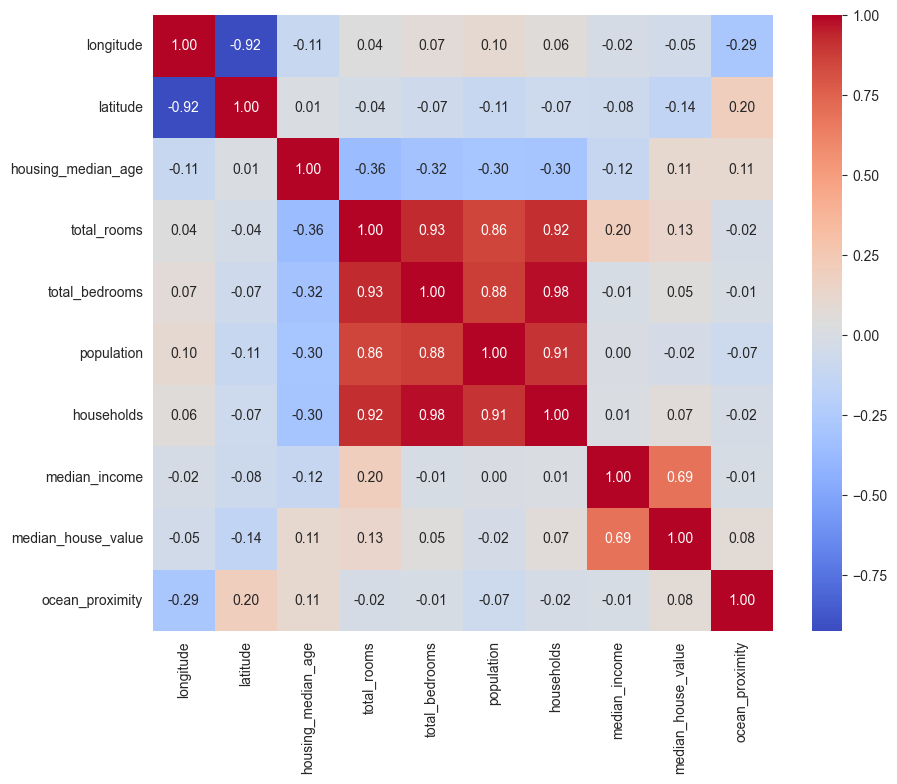

In [9]:
plt.figure(figsize=(10, 8))
sns.heatmap(housing_dataframe.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

## Check the distribution on each feature

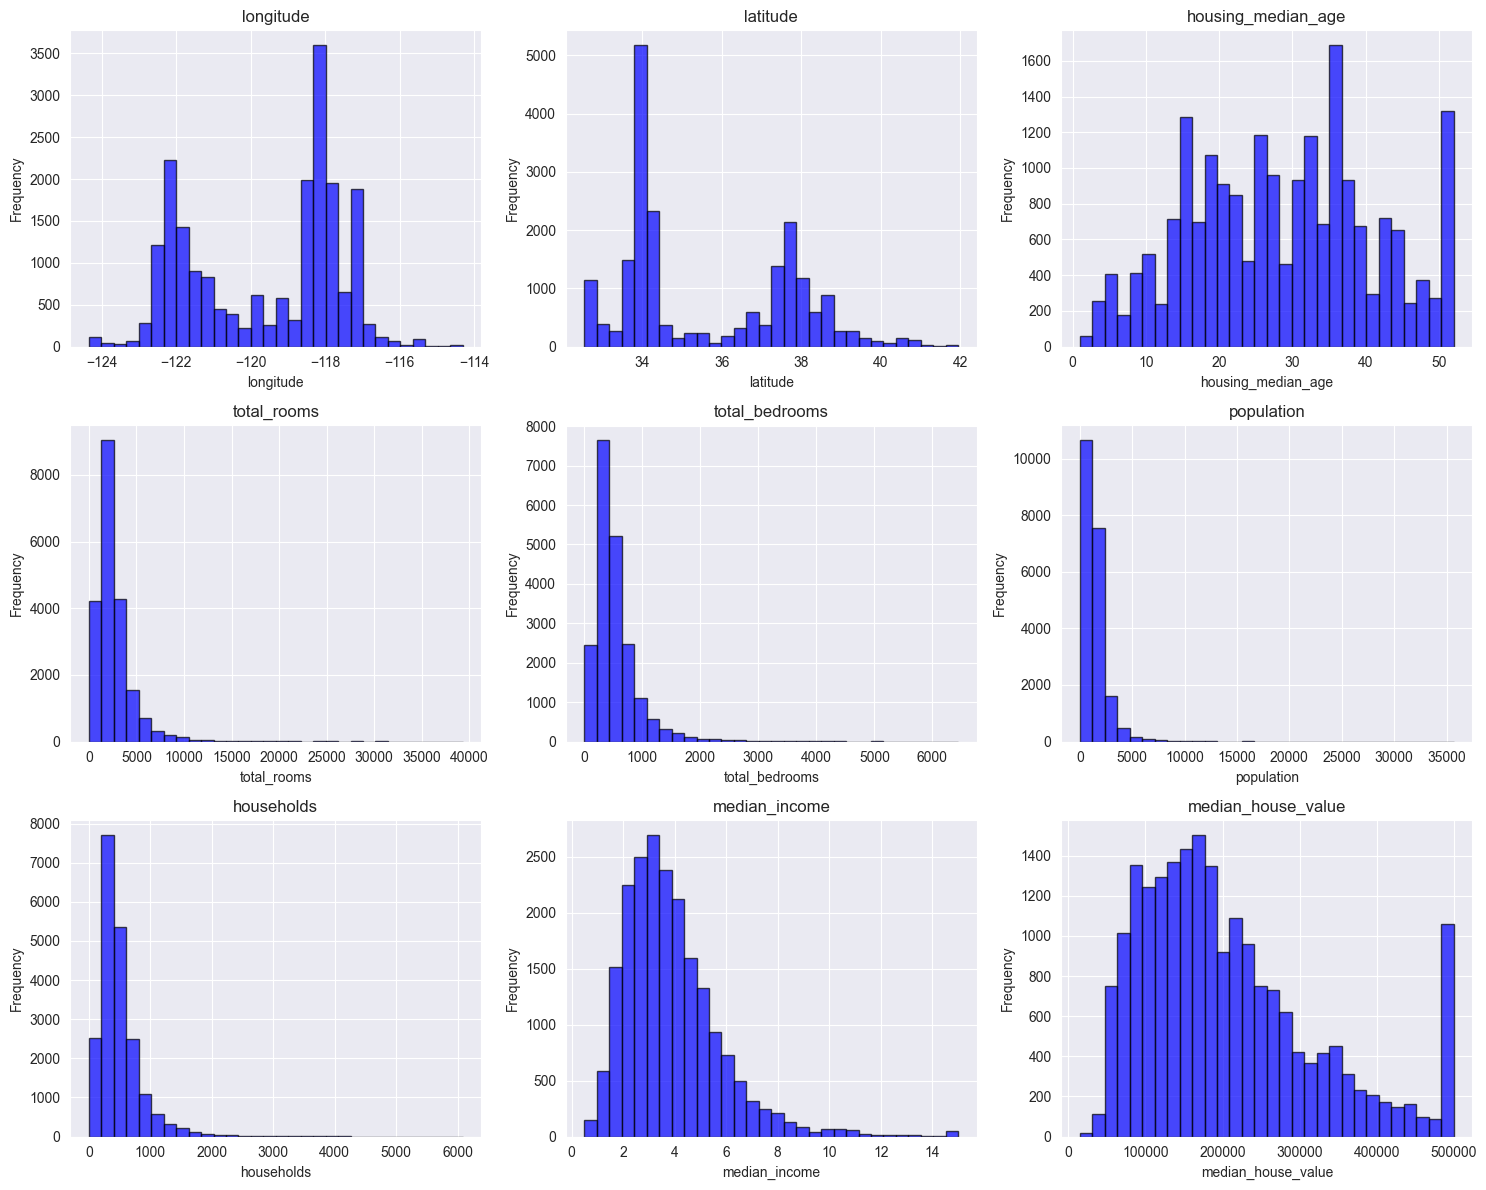

In [10]:
numeric_columns = housing_dataframe.select_dtypes(include=['float64', 'int64']).columns

plot_number_columns = 3  
plot_number_rows = (len(numeric_columns) + plot_number_columns - 1) // plot_number_columns  
plt.figure(figsize=(15, plot_number_rows * 4))  

for i, column in enumerate(numeric_columns, 1):
    plt.subplot(plot_number_rows, plot_number_columns, i)  
    plt.hist(housing_dataframe[column], bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(column) 
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Split data into features and target values

Our target value is median_house_value column of the dataframe.

In [11]:
features = housing_dataframe.drop(columns=['median_house_value'])  
targets = housing_dataframe['median_house_value'].values 
features.shape, targets.shape

((20640, 9), (20640,))

In [12]:
print("Mean Vector of features: ", np.mean(features))
print("Mean of target prices: ", np.mean(targets))
print("Standard Deviation vector of features: ", np.std(features))
print("Standard Deviation of target prices: ", np.std(targets))

Mean Vector of features:  560.957750990283
Mean of target prices:  206855.81690891474
Standard Deviation vector of features:  longitude                2.003483
latitude                 2.135901
housing_median_age      12.585253
total_rooms           2181.562402
total_bedrooms         421.374759
population            1132.434688
households             382.320491
median_income            1.899776
ocean_proximity          1.420628
dtype: float64
Standard Deviation of target prices:  115392.82040412253


D:\Programs\Anaconda\envs\testing_env\lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


## Normalize Features (opt out for now to test changes on predictions)

Prediction values were normalized as well and close to 0, so I'm testing without this.

In [13]:
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

features_normalized = feature_scaler.fit_transform(features)
targets_normalized = target_scaler.fit_transform(targets.reshape(-1, 1))

print("Features shape:", features_normalized.shape)
print("Targets shape:", targets_normalized.shape)

Features shape: (20640, 9)
Targets shape: (20640, 1)


## Use just a fraction of data (for performance and time issues)

In [14]:
subset_fraction = 0.1 
subset_features, _, subset_targets, _ = train_test_split(
    features_normalized, targets_normalized, 
    test_size=(1 - subset_fraction), 
    random_state=42
)
subset_features.shape, subset_targets.shape

((2064, 9), (2064, 1))

## Split data into training and testing

In [15]:
training_features, testing_features, training_targets, testing_targets = train_test_split(subset_features, subset_targets, test_size=0.2, random_state=42)
training_features.shape, testing_features.shape, training_targets.shape, testing_targets.shape

((1651, 9), (413, 9), (1651, 1), (413, 1))

In [16]:
print("Mean of training features: ", np.mean(training_features))
print("Mean of testing features: ", np.mean(testing_features))
print("Mean of training targets: ", np.mean(training_targets))
print("Mean of testing targets: ", np.mean(testing_targets))
print("Standard Deviation of training features: ", np.std(training_features))
print("Standard Deviation of testing features: ", np.std(testing_features))
print("Standard Deviation of training targets: ", np.std(training_targets))
print("Standard Deviation of testing targets: ", np.std(testing_targets))

Mean of training features:  -0.0018504444401983612
Mean of testing features:  0.01442004947961341
Mean of training targets:  -0.018936552193470953
Mean of testing targets:  0.06669435665251733
Standard Deviation of training features:  1.035734405096662
Standard Deviation of testing features:  0.9603824426214513
Standard Deviation of training targets:  0.9974454291523375
Standard Deviation of testing targets:  1.0503132232872654


## Bayesian Neural Network for Regression - Architecture

In [17]:
def regression_bayesian_network(features_params, targets_params, n_hidden=32, prior_std=1.0, likelihood_std=1.0):
    with pm.Model() as regression_bnn_model:
        features_data = pm.Data("features_params", features_params)
        targets_data = pm.Data("targets_params", targets_params)

        weights_1 = pm.Normal("weights_1", mu=0, sigma=prior_std, shape=(features_params.shape[1], n_hidden))
        bias_1 = pm.Normal("bias_1", mu=0, sigma=prior_std, shape=(n_hidden,))

        hidden_1 = pt.tanh(pt.dot(features_data, weights_1) + bias_1)

        weights_2 = pm.Normal("weights_2", mu=0, sigma=prior_std, shape=(n_hidden, n_hidden))
        bias_2 = pm.Normal("bias_2", mu=0, sigma=prior_std, shape=(n_hidden,))
        
        hidden_2 = pt.tanh(pt.dot(hidden_1, weights_2) + bias_2)

        weights_out = pm.Normal("weights_out", mu=0, sigma=prior_std, shape=(n_hidden,))
        bias_out = pm.Normal("bias_out", mu=0, sigma=prior_std)

        raw_output = pt.dot(hidden_2, weights_out) + bias_out
        output = pm.Deterministic("output", pt.expand_dims(raw_output, axis=1))

        sigma = pm.HalfNormal("sigma", sigma=likelihood_std)
        likelihood = pm.Normal("likelihood", mu=output, sigma=sigma, observed=targets_data)
        likelihood_output = pm.Deterministic("likelihood_output", likelihood)
        
        trace = pm.sample(
            1000,
            return_inferencedata=True,
            tune=4000,
            progressbar=True,
            idata_kwargs={"log_likelihood": True},
            target_accept=0.95
        )

    return regression_bnn_model, trace

In [19]:
regression_bayesian_network_model, regression_bayesian_network_trace = regression_bayesian_network(
    training_features,
    training_targets,
    n_hidden=32,
    prior_std=1.0,
    likelihood_std=np.std(training_targets)
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights_1, bias_1, weights_2, bias_2, weights_out, bias_out, sigma]


Output()

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 24355 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


D:\Programs\Anaconda\envs\testing_env\lib\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


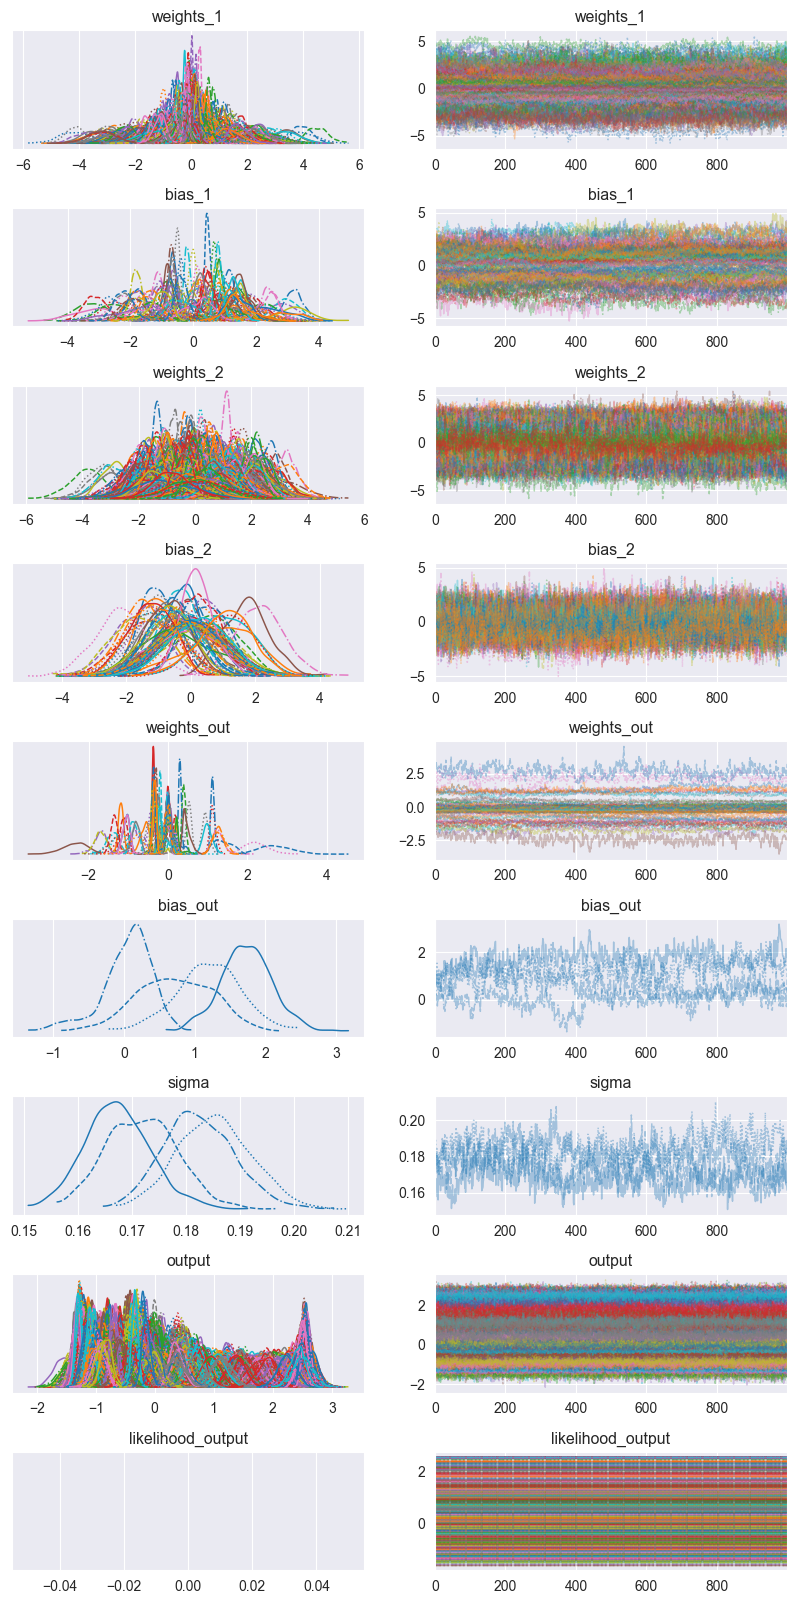

In [64]:
fig = az.plot_trace(regression_bayesian_network_trace, figsize=(10, 20))
plt.subplots_adjust(hspace=0.5) 
plt.show()

## Evaluating it on the training set

In [177]:
with regression_bayesian_network_model:
    posterior_pred_train = pm.sample_posterior_predictive(regression_bayesian_network_trace, var_names=["likelihood_output", "sigma"])

posterior_pred_train.posterior_predictive

Sampling: [likelihood, sigma]


Output()

<xarray.Dataset> Size: 13MB
Dimensions:                  (chain: 4, draw: 1000,
                              likelihood_output_dim_2: 413,
                              likelihood_output_dim_3: 1)
Coordinates:
  * chain                    (chain) int32 16B 0 1 2 3
  * draw                     (draw) int32 4kB 0 1 2 3 4 ... 995 996 997 998 999
  * likelihood_output_dim_2  (likelihood_output_dim_2) int32 2kB 0 1 ... 411 412
  * likelihood_output_dim_3  (likelihood_output_dim_3) int32 4B 0
Data variables:
    likelihood_output        (chain, draw, likelihood_output_dim_2, likelihood_output_dim_3) float64 13MB ...
    sigma                    (chain, draw) float64 32kB 1.286 0.2617 ... 0.6951
Attributes:
    created_at:                 2025-01-24T17:27:55.165502+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.20.0

In [176]:
regression_bayesian_network_trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [22]:
posterior_pred_train.posterior_predictive["likelihood_output"].shape

(4, 1000, 1651, 1)

In [51]:
predictions_train = posterior_pred_train.posterior_predictive["likelihood_output"].mean(axis=(0, 1)).values
predictions_train += 1e-9
predictions_train_reshaped = predictions_train.reshape(-1, 1)
predictions_train_original_scale = target_scaler.inverse_transform(predictions_train_reshaped).flatten()

print("Predictions in original scale:", predictions_train_original_scale[:10])

Predictions in original scale: [217342.63355987  90308.14254984 115919.91783123 160124.88126094
 184249.53096355 230531.95613715 195922.19899313 276006.84772789
 500123.87462741 421481.23234539]


In [52]:
uncertainty_train = posterior_pred_train.posterior_predictive["likelihood_output"].std(axis=(0, 1))
threshold_train = uncertainty_train.mean() + 2 * uncertainty_train.std()
extrapolation_points_train = uncertainty_train > threshold_train
extrapolation_points_train = extrapolation_points_train.values.flatten()

predictive_entropy = entropy(predictions_train_original_scale, axis=0)
threshold_entropy = predictive_entropy.mean() + 2 * predictive_entropy.std()
extrapolation_points_entropy = predictive_entropy > threshold_entropy

print("Train extrapolation regions identified:", np.sum(extrapolation_points_train))
print("Train extrapolation regions identified with entropy:", np.sum(extrapolation_points_entropy))

Train extrapolation regions identified: 18
Train extrapolation regions identified with entropy: 0


In [54]:
print("Shape of training_targets:", training_targets.shape)
print("Shape of predictions:", predictions_train_original_scale.shape)
print("Shape of extrapolation_points:", extrapolation_points_train.shape)

Shape of training_targets: (1651, 1)
Shape of predictions: (1651,)
Shape of extrapolation_points: (1651,)


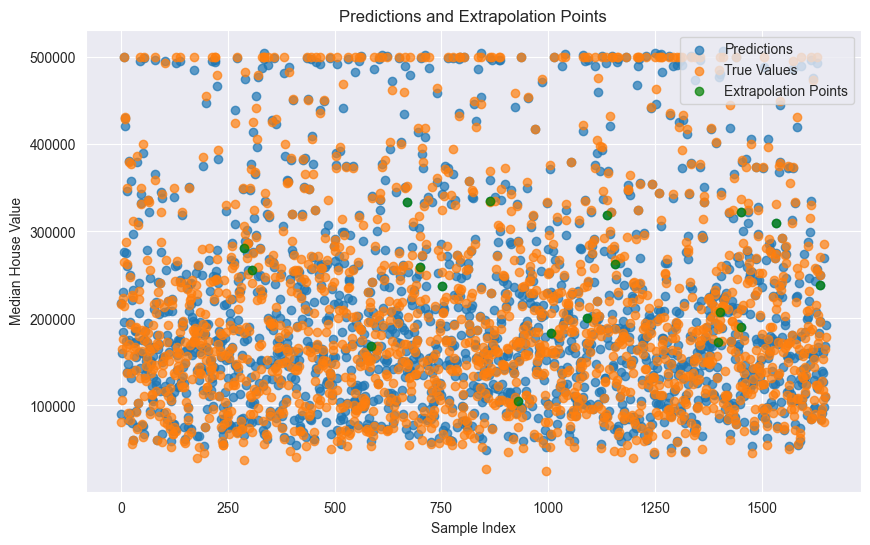

In [130]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(predictions_train_original_scale)), predictions_train_original_scale, label="Predictions", alpha=0.7)
plt.scatter(range(len(training_targets)), target_scaler.inverse_transform(training_targets).flatten(), label="True Values", alpha=0.7)
plt.scatter(
    np.where(extrapolation_points_train)[0], 
    predictions_train_original_scale[extrapolation_points_train],
    color="green", label="Extrapolation Points", alpha=0.7
)
plt.legend()
plt.title("Predictions and Extrapolation Points")
plt.xlabel("Sample Index")
plt.ylabel("Median House Value")
plt.show()

## Evaluating it on testing subset

In [58]:
with regression_bayesian_network_model:
    pm.set_data({"features_params": testing_features, "targets_params": testing_targets})
    posterior_pred_test = pm.sample_posterior_predictive(
        regression_bayesian_network_trace, var_names=["likelihood_output"]
    )

posterior_pred_test.posterior_predictive

Sampling: [likelihood]


Output()

<xarray.Dataset> Size: 13MB
Dimensions:                  (chain: 4, draw: 1000,
                              likelihood_output_dim_2: 413,
                              likelihood_output_dim_3: 1)
Coordinates:
  * chain                    (chain) int32 16B 0 1 2 3
  * draw                     (draw) int32 4kB 0 1 2 3 4 ... 995 996 997 998 999
  * likelihood_output_dim_2  (likelihood_output_dim_2) int32 2kB 0 1 ... 411 412
  * likelihood_output_dim_3  (likelihood_output_dim_3) int32 4B 0
Data variables:
    likelihood_output        (chain, draw, likelihood_output_dim_2, likelihood_output_dim_3) float64 13MB ...
Attributes:
    created_at:                 2025-01-24T10:44:44.475911+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.20.0

In [59]:
posterior_pred_test.posterior_predictive["likelihood_output"].shape

(4, 1000, 413, 1)

In [60]:
predictions_test = posterior_pred_test.posterior_predictive["likelihood_output"].mean(axis=(0, 1)).values
predictions_test += 1e-9  
predictions_test_reshaped = predictions_test.reshape(-1, 1)
predictions_test_original_scale = target_scaler.inverse_transform(predictions_test_reshaped).flatten()

print("Predictions for testing in original scale:", predictions_test_original_scale[:10])

Predictions for testing in original scale: [234730.68734274 409353.95600658  57025.93738655  99919.39064562
 239081.55686621 117202.12889563 469941.4366122  135659.8159613
 210074.71760409 475256.15052144]


In [61]:
uncertainty_test = posterior_pred_test.posterior_predictive["likelihood_output"].std(axis=(0, 1))
threshold_test = uncertainty_test.mean() + 2 * uncertainty_test.std()
extrapolation_points_test = uncertainty_test > threshold_test
extrapolation_points_test = extrapolation_points_test.values.flatten()

predictive_entropy_test = entropy(predictions_test_original_scale, axis=0)
threshold_entropy_test = predictive_entropy_test.mean() + 2 * predictive_entropy_test.std()
extrapolation_points_entropy_test = predictive_entropy_test > threshold_entropy_test

print("Test extrapolation regions identified:", np.sum(extrapolation_points_test))
print("Test extrapolation regions identified with entropy:", np.sum(extrapolation_points_entropy_test))

Test extrapolation regions identified: 18
Test extrapolation regions identified with entropy: 0


In [62]:
print("Shape of training_targets:", testing_targets.shape)
print("Shape of predictions:", predictions_test_original_scale.shape)
print("Shape of extrapolation_points:", extrapolation_points_test.shape)

Shape of training_targets: (413, 1)
Shape of predictions: (413,)
Shape of extrapolation_points: (413,)


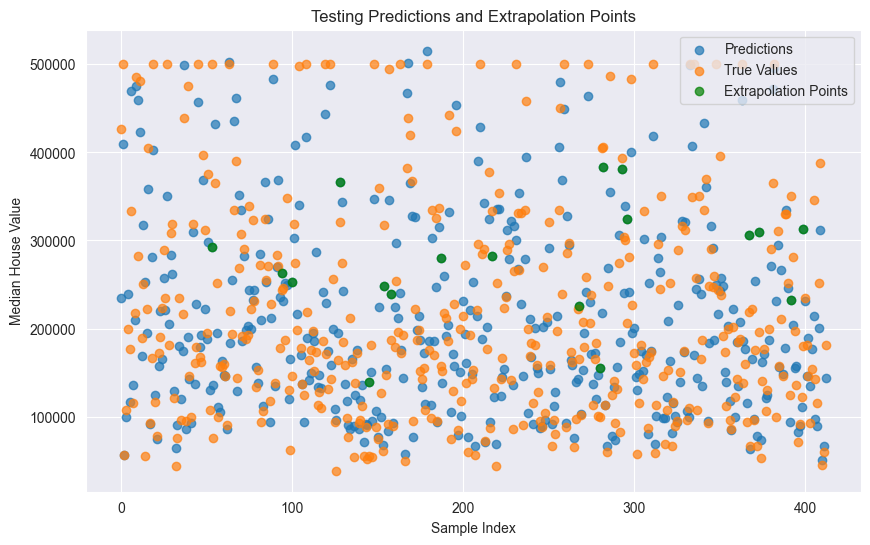

In [63]:
plt.figure(figsize=(10, 6))
plt.scatter(
    range(len(predictions_test_original_scale)),
    predictions_test_original_scale,
    label="Predictions", alpha=0.7
)
plt.scatter(
    range(len(testing_targets)),
    target_scaler.inverse_transform(testing_targets).flatten(),
    label="True Values", alpha=0.7
)
plt.scatter(
    np.where(extrapolation_points_test)[0],
    predictions_test_original_scale[extrapolation_points_test],
    color="green", label="Extrapolation Points", alpha=0.7
)
plt.legend()
plt.title("Testing Predictions and Extrapolation Points")
plt.xlabel("Sample Index")
plt.ylabel("Median House Value")
plt.show()

# Conclusions

## How to design the BNN using pymc and compare unseen classes

Before using entropy, I attempted a simple accuracy score for predictions sampling (would give a vector with values sample from the multivariable distribution obtained). 
That being said, I still fail to see how to make that comparison.

## Normalization of data helps BNN

This is what I've observed, at least for the regression problem. The remaining step is to revert the transformation at the end. But these additional steps are worth it for the accuracy of the predictions

## Subset the data, or decrease features

Sampling can take very long, and depending on the number of chains also, convergence might take very long to be attained. A compromise can be obtained in truncating data (less images, or less rows in regression), or decrease features(decrease image resolution, or get rid of columns that have very little influence over the target in regression).

## Bayesian Neural Networks vs Classical Neural Networks

The latter are faster to train and do inference on (the sampling time for the BNN is high). But how to measure uncertainty on classical networks? Well, comparison between accuracies isn't a good measure. However, BNNs explicitly model uncertainty by treating the weights of the network as random variables with prior probability distributions, rather than as fixed values and there is a measure based on entropy for comparison, for example. At least that should be the theory.